In [1]:
import sys
sys.path.append('..') 
from model_architectures import *
import numpy as np
import pandas as pd
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from collections import Counter

height, width = 10, 10

C:\Users\Sai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# Enable GPU usage for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f"Using device: {device}")
data = pd.read_csv(f"../archive/ascii_character_classification_{height}_x_{width}.csv", header=0)

label_counts = Counter(data.iloc[:, 0])
print(label_counts)

Using device: cuda
Counter({0: 50000, 51: 4886, 26: 4856, 54: 4848, 12: 4834, 58: 4833, 90: 4831, 31: 4827, 32: 4826, 62: 4825, 83: 4825, 60: 4823, 64: 4819, 56: 4819, 77: 4818, 79: 4816, 88: 4810, 80: 4806, 65: 4806, 92: 4804, 85: 4802, 20: 4800, 55: 4798, 93: 4795, 71: 4791, 45: 4789, 36: 4785, 22: 4783, 9: 4783, 34: 4782, 1: 4780, 5: 4779, 37: 4778, 33: 4777, 72: 4777, 70: 4775, 29: 4772, 40: 4770, 23: 4769, 35: 4769, 15: 4765, 69: 4764, 49: 4761, 8: 4759, 39: 4755, 73: 4746, 7: 4745, 59: 4741, 50: 4740, 4: 4740, 66: 4737, 87: 4735, 76: 4734, 44: 4731, 86: 4730, 74: 4727, 57: 4726, 28: 4724, 61: 4722, 82: 4719, 30: 4717, 21: 4714, 13: 4714, 89: 4713, 14: 4712, 10: 4699, 2: 4696, 18: 4695, 38: 4694, 81: 4693, 68: 4690, 91: 4690, 84: 4688, 3: 4688, 95: 4688, 53: 4687, 17: 4683, 16: 4682, 24: 4678, 75: 4677, 6: 4673, 46: 4665, 63: 4661, 27: 4642, 19: 4639, 43: 4631, 78: 4625, 11: 4624, 47: 4621, 41: 4619, 42: 4604, 67: 4603, 25: 4586, 48: 4584, 52: 4582, 94: 4576})


In [3]:
X = data.iloc[:, 1:].astype("float64")   # Features are all columns except the first one
y = data.iloc[:, 0].astype("float64")     # Labels are the first column

def extract_hog_features(images):
    hog_features = []
    for image in images:
        image_reshaped = image.reshape((10, 10))
        features = hog(image_reshaped, pixels_per_cell=(2, 2), cells_per_block=(1, 1), feature_vector=True)
        hog_features.append(features)
    return np.array(hog_features)

# X_hog = extract_hog_features(np.array(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:

X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32)
y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.long)
X_test_tensor = torch.tensor(np.array(X_test), dtype=torch.float32)
y_test_tensor = torch.tensor(np.array(y_test), dtype=torch.long)


batch_size = 1024
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

test_data = TensorDataset(X_train_tensor, y_train_tensor)
test_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)


input_features = X_train_tensor.size(1)
output_classes = 96

In [5]:
model = NeuralNetwork(input_features, 1024, 256, 64, output_classes)
model.to(device)

NeuralNetwork(
  (fc1): Linear(in_features=100, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=96, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Adjust step_size and gamma as needed

# Compute Train Accuracy
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        outputs = model(features)
        _, predicted_labels = torch.max(outputs, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum().item()
    return correct_pred / num_examples * 100

In [7]:
num_epochs = 10

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (features, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        features = features.to(device)
        labels = labels.to(device)

        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

    # scheduler.step()

    train_accuracy = compute_accuracy(model, train_loader, device)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Accuracy: {train_accuracy:.2f}%')

    # Save losses and accuracies
    train_losses.append(running_loss)
    train_accuracies.append(train_accuracy)

print('Training finished.')

Epoch [1/10], Step [100/391], Loss: 4.4686
Epoch [1/10], Step [200/391], Loss: 4.3470
Epoch [1/10], Step [300/391], Loss: 4.2944
Epoch [1/10], Training Accuracy: 30.67%
Epoch [2/10], Step [100/391], Loss: 4.2700
Epoch [2/10], Step [200/391], Loss: 4.2692
Epoch [2/10], Step [300/391], Loss: 4.2700
Epoch [2/10], Training Accuracy: 31.19%
Epoch [3/10], Step [100/391], Loss: 4.2664
Epoch [3/10], Step [200/391], Loss: 4.2645
Epoch [3/10], Step [300/391], Loss: 4.2647
Epoch [3/10], Training Accuracy: 31.71%
Epoch [4/10], Step [100/391], Loss: 4.2607
Epoch [4/10], Step [200/391], Loss: 4.2626
Epoch [4/10], Step [300/391], Loss: 4.2637
Epoch [4/10], Training Accuracy: 31.71%
Epoch [5/10], Step [100/391], Loss: 4.2602
Epoch [5/10], Step [200/391], Loss: 4.2604
Epoch [5/10], Step [300/391], Loss: 4.2619
Epoch [5/10], Training Accuracy: 32.86%
Epoch [6/10], Step [100/391], Loss: 4.2494
Epoch [6/10], Step [200/391], Loss: 4.2512
Epoch [6/10], Step [300/391], Loss: 4.2523
Epoch [6/10], Training Acc

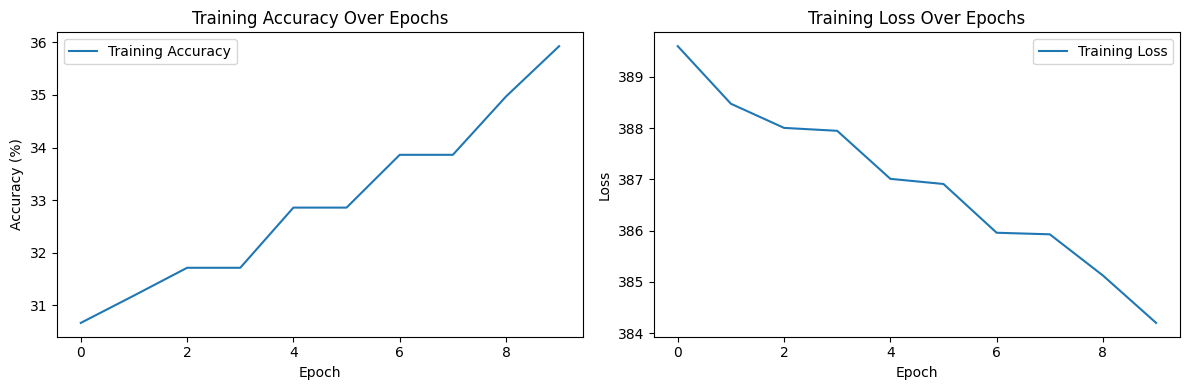

In [8]:
# Plotting training accuracies and losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
torch.save(model.state_dict(), f'../artifacts/nn_ascii_classifier_{height}_x_{width}.pth')

In [10]:
model.eval()

correct = 0
total = 0


with torch.no_grad():
    for i, (features, labels) in enumerate(test_loader):
        optimizer.zero_grad()

        features = features.to(device)
        labels = labels.to(device)

        outputs = model(features)
        probabilities = F.softmax(outputs, dim=1)
        
        _, predicted = torch.max(probabilities, 1)

        

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        


    
accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.4f}%')

Test Accuracy: 35.9260%
